<a href="https://colab.research.google.com/github/SanBartolome/IA-diploma-course-2021/blob/main/SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clase 4: Support Vector Machines

El objetivo de este ejercicio es consolidar la comprensión intuitiva de las SVM, y aprender experimentalmente a ajustar un modelo SVM.

*(Original adaptado del curso "Machine Learning" de Andrew NG, adaptado del material del curso "Aprendizaje Automático" de Cesar Olivares)*

## 1. SVM con kernel lineal

Empecemos con un conjunto de datos en 2D completamente separable por una frontera de decisión lineal. Importaremos los datos como un [`pandas.DataFrame`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html). Los datos se encuentran alojados en un enlace libre de drive, también están disponibles en la carpeta Código de PAIDEIA.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC 
from sklearn import preprocessing
%matplotlib inline

In [2]:
!wget 'https://drive.google.com/uc?export=download&id=19UGsjpICqXoTPqEsNUm7DDBlXkSQKtwl' -O ex6data1.csv
!wget 'https://drive.google.com/uc?export=download&id=1ISGGxpdb6YvrvWBCAzDzbUYN22y40oVg' -O ex6data2.csv
!wget 'https://drive.google.com/uc?export=download&id=1TTiu1cgekgb4b8YxsNGLM7NQAeUrdFaM' -O ex6data3val.csv
!wget 'https://drive.google.com/uc?export=download&id=1Jdz777tTPUf6ctCKe98WX0cjd4Rfsfjk' -O ex6data3train.csv

--2021-09-26 21:26:31--  https://drive.google.com/uc?export=download&id=19UGsjpICqXoTPqEsNUm7DDBlXkSQKtwl
Resolving drive.google.com (drive.google.com)... 142.251.45.110, 2607:f8b0:4004:83f::200e
Connecting to drive.google.com (drive.google.com)|142.251.45.110|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-10-3c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/5su87e8kfoj5d9og0hlkdc0hndcn1e9c/1632691575000/13307417494834192396/*/19UGsjpICqXoTPqEsNUm7DDBlXkSQKtwl?e=download [following]
--2021-09-26 21:26:32--  https://doc-10-3c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/5su87e8kfoj5d9og0hlkdc0hndcn1e9c/1632691575000/13307417494834192396/*/19UGsjpICqXoTPqEsNUm7DDBlXkSQKtwl?e=download
Resolving doc-10-3c-docs.googleusercontent.com (doc-10-3c-docs.googleusercontent.com)... 142.250.188.33, 2607:f8b0:4004:835::2001
Connecting to doc-10-3c-docs.googleusercontent.com (doc-10-3c-docs.

Siempre es bueno hacernos una idea inicial de los datos. Veamos sus principales parámetros estadísticos:

In [3]:
data1 = pd.read_csv('ex6data1.csv', names=['x1', 'x2', 'y'])

In [4]:
# Mostrar estadistica descriptiva
data1.describe()

,x1,x2,y
count,51.000000,51.000000,51.000000
mean,2.268780,3.132512,0.411765
std,0.928531,0.753256,0.497050
min,0.086405,1.617700,0.000000
25%,1.572550,2.636000,0.000000
50%,2.275300,3.070900,0.000000
75%,2.955050,3.531400,1.000000
max,4.015000,4.616200,1.000000


Veamos ahora los primeros 5 del total de 51 elementos:

In [5]:
# Mostrar los primeros 5 elementos del conjunto de datos
data1.head()

,x1,x2,y
0,1.9643,4.5957,1
1,2.2753,3.8589,1
2,2.9781,4.5651,1
3,2.9320,3.5519,1
4,3.5772,2.8560,1


También es posible mostrar fácilmente diagramas de caja:

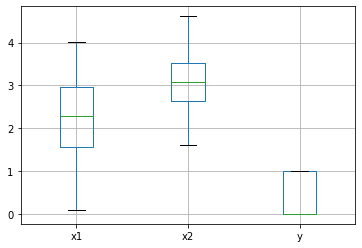

In [6]:
data1.boxplot(return_type='axes')

Para mayor claridad, separaremos $X$ y $y$.

In [7]:
X = data1[['x1', 'x2']]
y = data1['y']

Veamos también la distribución de valores $y$:

Distribución de valores de y:
0    30
1    21
Name: y, dtype: int64


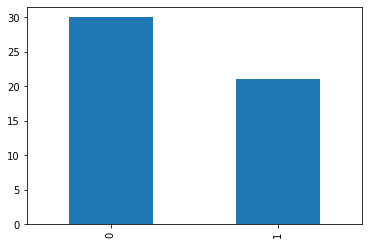

In [8]:
print( 'Distribución de valores de y:' )
print( data1['y'].value_counts() )

data1['y'].value_counts().plot.bar()

Visualicemos $X$ en un diagrama de dispersión, usando colores para distinguir las etiquetas de clase $y \in [0, 1]$ con los colores rojo $(0)$ y verde $(1)$:

In [9]:
def plotPoints2D(X1, X2, title, marker_size=30):
  plt.title(title)
  plt.margins(x=0, y=0)
  plt.xlabel('x1')
  plt.ylabel('x2')
  plt.scatter(X1, X2, c=y, s=marker_size, cmap='prism');

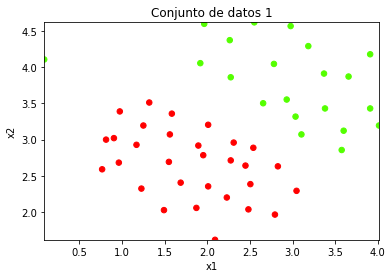

In [10]:
plotPoints2D(X['x1'], X['x2'],'Conjunto de datos 1')

En este conjunto de datos, la posición de los ejemplos sugiere una separación natural, un espacio o brecha entre ambos subconjuntos. Sin embargo, se puede observar también un valor atípico positivo en la parte superior izquierda $(0.1, 4.1)$. Como parte de este ejercicio vamos a ver cómo este valor atípico afecta la frontera de decisión de SVM.

### Efecto del parámetro $C$

En esta parte del ejercicio, vamos a probar ajustar modelos SVM con diferentes valores del parámetro $C$. Cuando $C$ es grande, el modelo SVM tratará de clasificar todos los ejemplos correctamente. $C$ juega un rol similar a $\frac{1}{\lambda}$, donde $\lambda$ es el parámetro de regularización estudiado en la regresión logística.

Vamos a usar SVC, que es una implementación del modelo SVM que viene incluida en scikit-learn y está basada en la librería *libsvm*.

Usemos en primer lugar un valor $C = 1$.

In [11]:
from sklearn.svm import SVC # "Support vector classifier"

# Ajuste del modelo SVM con C=1
model = SVC(kernel='linear', C=1)
model.fit(X, y)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Para visualizar mejor los datos, definiremos una función de apoyo.

In [12]:
# Tomado del libro 'Python Data Science Handbook' de Jake VanderPlas
def plot_svc_decision_function(model, ax=None, plot_support=True, levels=[-1, 0, 1], linestyles=['--', '-', '--']):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=levels, alpha=0.5,
               linestyles=linestyles)
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1,facecolors='none',edgecolors='b');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

Cuando $C = 1$, se observa que el modelo SVM coloca la frontera de decisión en la brecha que existe entre los dos subconjuntos de datos, y *clasifica mal* el valor atípico de la región superior izquierda. 

Los vectores de soporte están destacados con un círculo a su alrededor. Son todos aquellos que **no** se encuentran del lado correcto de la frontera de decisión con una distancia $m < 1$

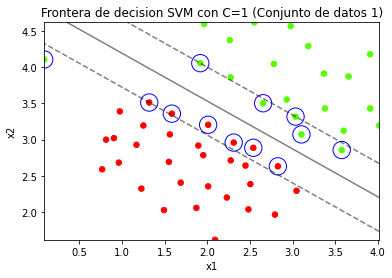

In [13]:
plotPoints2D(X['x1'], X['x2'],'Frontera de decision SVM con C=1 (Conjunto de datos 1)')
plot_svc_decision_function(model)

A continuación, se probará diferentes valores de $C$ en este conjunto de datos. Específicamente con los valores $C = 20$ y $C = 100$.

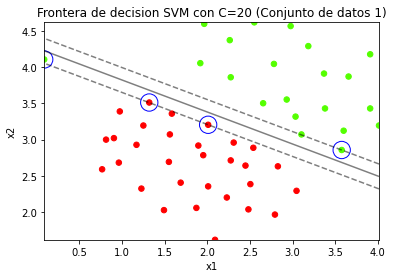

In [14]:
# Ajuste del modelo con C = 20
model20 = SVC(kernel='linear', C=20)
model20.fit(X, y)

# Visualización del modelo
plotPoints2D(X['x1'], X['x2'],'Frontera de decision SVM con C=20 (Conjunto de datos 1)')
plot_svc_decision_function(model20) 

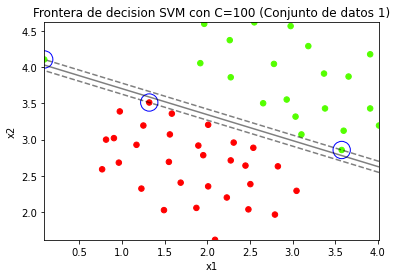

In [15]:
# Ajuste del modelo con C = 100
model100 = SVC(kernel='linear', C=100)
model100.fit(X, y)

# Visualización del modelo
plotPoints2D(X['x1'], X['x2'],'Frontera de decision SVM con C=100 (Conjunto de datos 1)')
plot_svc_decision_function(model100) 

Conteste las siguientes preguntas:

**Pregunta 1:** ¿Cuántos vectores de soporte resultan al entrenar el modelo SVM con un kernel lineal y un valor $C = 20$?

**Pregunta 2:** En el modelo con $C = 20$, ¿se clasifica correctamente el valor atípico ubicado en $(0.1, 4.1)$?

**Pregunta 3:** ¿Cuántos vectores de soporte resultan al entrenar el modelo SVM con un kernel lineal y un valor $C = 100$?

**Pregunta 4:** En el modelo con $C = 100$, ¿se clasifica correctamente el valor atípico ubicado en $(0.1, 4.1)$?

**Pregunta 5:** ¿La frontera de decisión del modelo $C = 100$ coincide con la separación natural entre los datos? 


In [16]:
# Pregunta 1
print("support vectors:", len(model20.support_))
# 4 vectores

support vectors: 4


In [32]:
# Pregunta 2
misclassified20 = np.where(y != model20.predict(X))
print(misclassified20)

(array([50]),)


In [30]:
print(str(X['x1'][50]), ",", str(X['x2'][50]))
# El valor atípico está incorrectamente clasificado

0.086405 , 4.1045


In [17]:
# Pregunta 3
print("support vectors:", len(model100.support_))
# 3 vectores

support vectors: 3


In [33]:
# Pregunta 4
misclassified100 = np.where(y != model100.predict(X))
print(misclassified100)
# El valor atípico está correctamente clasificado

(array([], dtype=int64),)


In [37]:
# Pregunta 5
print(model100.score(X, y))
#La frontera de decisión coincide con la separaicón natural

1.0


## 2. SVM con kernel gaussiano

En esta parte del ejercicio usaremos SVMs para clasificación no lineal. Específicamente, usaremos SVMs con kernels gaussianos en conjuntos de datos que no son linealmente separables.

### 2.1. Conjunto de datos 2


In [38]:
data2 = pd.read_csv('ex6data2.csv', names=['x1', 'x2', 'y'])
X = data2[['x1', 'x2']]
y = data2['y']

data2.describe()

,x1,x2,y
count,863.000000,863.000000,863.000000
mean,0.503414,0.694304,0.556199
std,0.254967,0.158884,0.497120
min,0.044931,0.402630,0.000000
25%,0.292625,0.557020,0.000000
50%,0.512670,0.693710,1.000000
75%,0.699310,0.830410,1.000000
max,0.998850,0.988600,1.000000


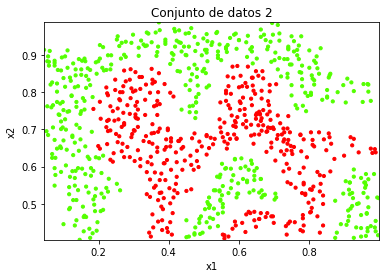

In [39]:
plotPoints2D(X['x1'], X['x2'],'Conjunto de datos 2',marker_size=10)

Podemos observar que en el conjunto de datos 2 no hay una frontera de decisión lineal que pueda separar los ejemplos positivos y negativos. Sin embargo, usando SVM con kernel gaussiano, se puede aprender una frontera de decisión no lineal que se desempeñe razonablemente bien en este conjunto de datos.

Antes de usar un kernel gaussiano, es importante normalizar el conjunto de datos $X$. Si bien en este caso $x_1$ y $x_2$ ya tienen un mismo rango $[0, 1]$, aplicaremos de todos modos un [escalador estándar](http://scikit-learn.org/stable/modules/preprocessing.html#standardization-or-mean-removal-and-variance-scaling). El escalador estándar recibe $X$ y registra la media y desviación estándar, las cuales utilizará para transformar los datos. (Comparar con la estadística descriptiva dos pasos más arriba.)

In [40]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X)
scaler

StandardScaler(copy=True, with_mean=True, with_std=True)

In [41]:
scaler.mean_

array([0.5034135 , 0.69430429])

In [42]:
scaler.scale_

array([0.25481939, 0.15879163])

Para obtener los datos estandarizados, aplicamos la función `transform`:

In [43]:
X_scaled = scaler.transform(X)

`X_scaled` es un arreglo `numpy`. Usemos `pandas` para mostrar el sumario estadístico. Podemos verificar que los datos están normalizados con una media $\mu \approx 0$ y una desviación estándar $\sigma \approx 1$:

In [44]:
pd.DataFrame(X_scaled).describe()

,0,1
count,8.630000e+02,8.630000e+02
mean,-3.787366e-16,-6.900621e-16
std,1.000580e+00,1.000580e+00
min,-1.799245e+00,-1.836837e+00
25%,-8.272075e-01,-8.645562e-01
50%,3.632572e-02,-3.742561e-03
75%,7.687661e-01,8.571341e-01
max,1.944265e+00,1.853345e+00


Ahora sí ajustemos el modelo SVM con kernel gaussiano *(Radial Basis Function)*.

In [45]:
# Ajuste de modelo con kernel gaussiano
model = SVC(kernel='rbf', C=1, gamma=50)
model.fit(X_scaled, y)


SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=50, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Haremos la visualización con los datos normalizados. Dado que `X_scaled` es un arreglo `numpy`, accedemos a sus columnas $x_1$ y $x_2$ como `X_scaled[:,0]` y `X_scaled[:,1]`:

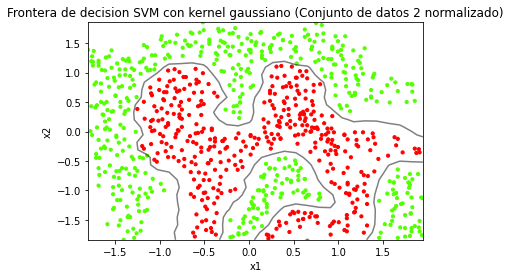

In [46]:
# Visualización
plotPoints2D(X_scaled[:,0], X_scaled[:,1],'Frontera de decision SVM con kernel gaussiano (Conjunto de datos 2 normalizado)',marker_size=10)
plot_svc_decision_function(model, plot_support=False, levels=[0], linestyles=['-']) 

Por medio del método `score` podemos obtener la exactitud *(accuracy)* del modelo ajustado.

In [47]:
score = model.score(X_scaled, y)
tasa_de_error = (1- score)
n_ejemplos = len(X)
n_aciertos = score * len(X) 
n_errores = n_ejemplos - n_aciertos 

print ('Total de ejemplos: %d' % n_ejemplos)
print ('Exactitud: %0.4f' % score)
print ('Tasa de error: %0.4f' % tasa_de_error)
print ('Número de ejemplos correctamente clasificados: %d' % n_aciertos)
print ('Número de ejemplos incorrectamente clasificados: %d' % n_errores)


Total de ejemplos: 863
Exactitud: 1.0000
Tasa de error: 0.0000
Número de ejemplos correctamente clasificados: 863
Número de ejemplos incorrectamente clasificados: 0


### 2.2. Conjunto de datos 3

En esta parte del ejercicio vamos a aprender a seleccionar los parámetros $C$ y $\gamma$ requeridos por el kernel gaussiano.

La selección de los modelos de un parámetro se realiza por medio de *validación cruzada*. Para ello se reserva una muestra aleatoria del conjunto de datos que pueda servir para estimar el grado de generalización de los modelos a evaluar.

Para asegurar los mismos resultados, en este ejercicio recibimos directamente el conjunto de entrenamiento `(X, y)` y el conjunto de validación `(Xval, yval)`.

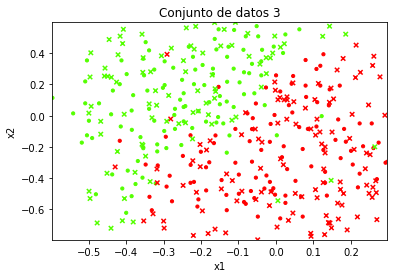

In [48]:
data3train = pd.read_csv('ex6data3train.csv', names=['x1', 'x2', 'y'])
X = data3train[['x1', 'x2']]
y = data3train['y']

data3val = pd.read_csv('ex6data3val.csv', names=['x1', 'x2', 'y'])
Xval = data3val[['x1', 'x2']]
yval = data3val['y']

plt.title('Conjunto de datos 3')
plt.margins(x=0, y=0)
plt.xlabel('x1')
plt.ylabel('x2')
plt.scatter(X['x1'], X['x2'], c=y, s=10, cmap='prism', label='Conjunto de entrenamiento')
plt.scatter(Xval['x1'], Xval['x2'], c=yval, marker='x', s=20, cmap='prism', label='Conjunto de validacion')
plt.show()


Realizaremos también la normalización de los datos. Presta atención a que la normalización de los datos de validación $X_{val}$ se debe realizar con los parámetros obtenidos del conjunto de entrenamiento $X$.

In [49]:
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)
Xval_scaled = scaler.transform(Xval)

Comparemos la exactitud en los conjuntos de entrenamiento y validación para un modelo con $C=200$ y $\gamma = 50$

In [50]:
model = SVC(kernel='rbf', C=200, gamma=50)
model.fit(X_scaled, y)
score_train = model.score(X_scaled, y)
score_val = model.score(Xval_scaled, yval)

print ('Exactitud en el conjunto de entrenamiento: %0.4f' % score_train)
print ('Exactitud en el conjunto de validación: %0.4f' % score_val)


Exactitud en el conjunto de entrenamiento: 1.0000
Exactitud en el conjunto de validación: 0.8800


Si bien se tiene una exactitud muy alta en el conjunto de entrenamiento, la exactitud es bastante menor en el conjunto de validación. Este es un síntoma claro de sobreajuste *(overfitting)*. Visualicemos lo que está ocurriendo.

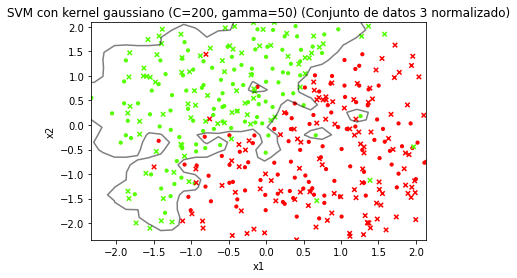

In [51]:
# Visualización
plt.title('SVM con kernel gaussiano (C=200, gamma=50) (Conjunto de datos 3 normalizado)')
plt.margins(x=0, y=0)
plt.xlabel('x1')
plt.ylabel('x2')
plt.scatter(X_scaled[:,0], X_scaled[:,1], c=y, s=10, cmap='prism', label='Conjunto de entrenamiento')
plt.scatter(Xval_scaled[:,0], Xval_scaled[:,1], c=yval, marker='x', s=20, cmap='prism', label='Conjunto de validacion')
plot_svc_decision_function(model, plot_support=False, levels=[0], linestyles=['-']) 


Podemos apreciar visualmente que la generalización es deficiente porque el modelo está **"memorizando"** la ubicación de los valores atípicos. Este no es un comportamiento deseable.

Para determinar valores $C$ y $\gamma$ que brinden una mejor generalización, es necesario probar con diferentes valores, ajustando el modelo en el conjunto de entrenamiento y probando su desempeño en el conjunto de validación. Esta estratégia se conoce como grid search.

Mejor valor de C: 1.0000
Mejor valor de gamma: 10.0000
Exactitud en el conjunto de entrenamiento: 0.9479
Exactitud en el conjunto de validación: 0.9600


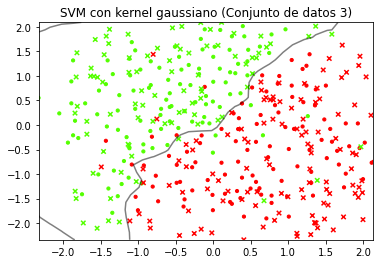

In [52]:
Cs = np.logspace(-2,2,9)  # ~ [0.01, 0.03, 0.1, ..., 100]
gammas = np.logspace(-4,4,9)  # [0.0001, 0.001, ..., 10000]

mejor_modelo = None
mejor_score = 0
for C in Cs:
    for gamma in gammas:
        
        model = SVC(kernel='rbf', C=C, gamma=gamma) 
        model.fit(X_scaled, y)
        
        score_val = model.score(Xval_scaled, yval) 
        
        if score_val > mejor_score:
            mejor_score = score_val
            mejor_modelo = model


print ('Mejor valor de C: %0.4f' % mejor_modelo.get_params()['C'])
print ('Mejor valor de gamma: %0.4f' % mejor_modelo.get_params()['gamma'])
print ('Exactitud en el conjunto de entrenamiento: %0.4f' % mejor_modelo.score(X_scaled, y))
print ('Exactitud en el conjunto de validación: %0.4f' % mejor_modelo.score(Xval_scaled, yval))

# Visualización
plt.title('SVM con kernel gaussiano (Conjunto de datos 3)')
plt.margins(x=0, y=0)
plt.scatter(X_scaled[:,0], X_scaled[:,1], c=y, s=10, cmap='prism', label='Conjunto de entrenamiento')
plt.scatter(Xval_scaled[:,0], Xval_scaled[:,1], c=yval, marker='x', s=20, cmap='prism', label='Conjunto de validacion')
plot_svc_decision_function(mejor_modelo, plot_support=False, levels=[0], linestyles=['-']) 


Observe la forma de la frontera de decisión de su mejor modelo y compárela con la obtenida arriba con $C=200$ y $\gamma = 50$. Luego responda las siguientes preguntas sobre el mejor modelo:

**Pregunta 6:** ¿Cuál fue el mejor valor de $C$ obtenido? ¿Cuál fue el mejor valor de $\gamma$ obtenido? ¿Se obtuvo una mejor exactitud en el conjunto de entrenamiento o en el conjunto de validación?

**Pregunta 7:** Comente las gráficas de las funciones de decisión en relación a los parámetros parámetro C y gamma.

Pregunta 6<br>
Se puede considerar que los mejores valores obtenidos son con C = 1 y gamma = 10. Si bien con C = 200 y gamma = 50 se obtuvo exactitud 1 con la data de entrenamiento, su exactitud en la validación es inferior. Esto se interpretaría con que solo tendría un resultado óptimo con ese grupo en particular, mientras que C = 1 y gamma = 10 es más equilibrado.

Pregunta 7<br>
En la gráfica de C = 200 y gamma = 50 al tener valores tan ajustados los valores atípicos resaltan más, impactando en la frontera de decisión.<br>
En la gráfica de C = 1 y gamma = 10 los valores atípicos son más ignorados pero la frontera de decisión se encuentra más definida.

# Aplicaciones prácticas: Breast Cancer

In [53]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

Carga de datos y separación en conjuntos de entrenamiento y validación. 

Dataset: https://scikit-learn.org/stable/datasets/toy_dataset.html#breast-cancer-dataset

Clases: 212 - Malignant, 357 - Benign

In [54]:
data = load_breast_cancer()
Xtrain, Xtest, Ytrain, Ytest = train_test_split(data.data, data.target, test_size=0.33, random_state=0)

Preprocesamiento de datos

In [55]:
scaler = StandardScaler()
Xtrain = scaler.fit_transform(Xtrain)
Xtest = scaler.transform(Xtest)

Entrenamiento del modelo y obtención del score.

In [56]:
# Utilizaremos una función para entrenar, validar e imprimir resultados
def testSVCModel(Xtrain, Xtest, Ytrain, Ytest, kernel='linear', C=10., gamma=.05, degree=2):
  if kernel == 'linear':
    model = SVC(kernel=kernel,C=C)
  elif kernel =='poly':
    model = SVC(kernel=kernel,C=C, degree=degree)
  else:
    model = SVC(kernel=kernel,C=C, gamma=gamma)
  model.fit(Xtrain, Ytrain)
  print("train score:", model.score(Xtrain, Ytrain))
  print("test score:", model.score(Xtest, Ytest))
  return model

In [57]:
model = testSVCModel(Xtrain, Xtest, Ytrain, Ytest,'rbf',4.,.05)

train score: 0.9868766404199475
test score: 0.9680851063829787


Exploración de otras métricas (precision, recall, f1-score) (0=M) (1=B):

**Precisión para una clase C**: Número de predicciones de clase C correctas/Número de predicciones de clase C.

**Recall para una clase C:** Número de predicicciones de clase C correctas/Número de elementos de clase C.

**F1-score para una clase C:** 2 * (precision * recall) / (precision + recall)


In [58]:
Ypred = model.predict(Xtest)
print(classification_report(Ytest,Ypred))

              precision    recall  f1-score   support

           0       0.94      0.97      0.96        67
           1       0.98      0.97      0.97       121

    accuracy                           0.97       188
   macro avg       0.96      0.97      0.97       188
weighted avg       0.97      0.97      0.97       188



Impresión de la matriz de confusión.

In [59]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
        
    Reference
    -------
    https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823
    
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    print(fig)

Figure(720x504)


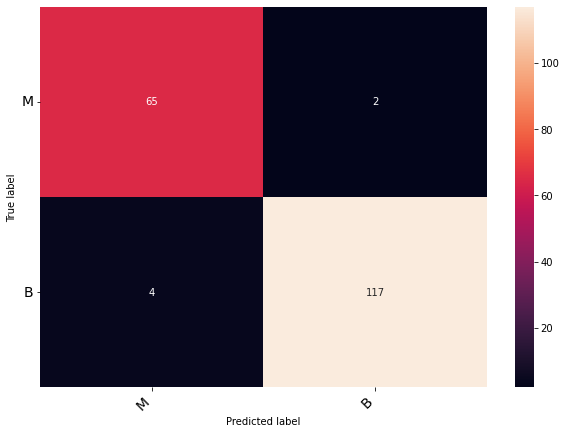

In [60]:
print_confusion_matrix(confusion_matrix(Ytest, Ypred),["M","B"])

Pruebas con kernel linear

In [61]:
testSVCModel(Xtrain, Xtest, Ytrain, Ytest, kernel='linear',C=4.,gamma=.05)

train score: 0.989501312335958
test score: 0.9468085106382979


SVC(C=4.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Pruebas con kernel polinomial de grados 2, 3 y 4

In [62]:
testSVCModel(Xtrain, Xtest, Ytrain, Ytest, kernel='poly',C=4.,degree=2)

train score: 0.884514435695538
test score: 0.8031914893617021


SVC(C=4.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=2, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [63]:
testSVCModel(Xtrain, Xtest, Ytrain, Ytest, kernel='poly',C=4.,degree=3)

train score: 0.9448818897637795
test score: 0.9627659574468085


SVC(C=4.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [64]:
testSVCModel(Xtrain, Xtest, Ytrain, Ytest, kernel='poly',C=4.,degree=4)

train score: 0.889763779527559
test score: 0.7819148936170213


SVC(C=4.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=4, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

**Pregunta 8:** Se ha definido un conjunto de valores para C y gamma. Implemente un grid search para encontrar el mejor par de hiperparámetros (C, gamma) para un modelo SVM con kernel gaussiano.

In [65]:
Cs = np.logspace(-2,2,9)  # ~ [0.01, 0.03, 0.1, ..., 100]
gammas = np.logspace(-4,4,9)  # [0.0001, 0.001, ..., 10000]

mejor_modelo = None

## Completar...
mejor_score = 0
for C in Cs:
    for gamma in gammas:
        
        model = SVC(kernel='rbf', C=C, gamma=gamma) 
        model.fit(Xtrain, Ytrain)
        
        score_val = model.score(Xtest, Ytest) 
        
        if score_val > mejor_score:
            mejor_score = score_val
            mejor_modelo = model

print ('Mejor valor de C: %0.4f' % mejor_modelo.get_params()['C'])
print ('Mejor valor de gamma: %0.4f' % mejor_modelo.get_params()['gamma'])
print ('Exactitud en el conjunto de entrenamiento: %0.8f' % mejor_modelo.score(Xtrain, Ytrain))
print ('Exactitud en el conjunto de validación: %0.8f' % mejor_modelo.score(Xtest, Ytest))

Mejor valor de C: 100.0000
Mejor valor de gamma: 0.0010
Exactitud en el conjunto de entrenamiento: 0.98687664
Exactitud en el conjunto de validación: 0.98404255
